<a id='beginning'></a>

# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Описание проекта:**

На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей

**Содержание проекта:**

**[1. Загрузка данных;](#step_1)**

**[2. Исследовательский анализ данных (EDA);](#step_2)**

**[3. Модель прогнозирования оттока клиентов;](#step_3)**

**[4. Кластеризация клиентов;](#step_4)**

**[5. Выводы и базовые рекомендации по работе с клиентами.](#step_5)**


**Файл с данными `gym_churn.csv` содержит данные на месяц до оттока и факт оттока на определённый месяц.**

| Название столбца |Описание данных |
|:-----------------|:---------------|
|**churn**|факт оттока в текущем месяце|
|**gender**|пол|
|**near_location**|проживание или работа в районе, где находится фитнес-центр|
|**partner**|сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)|
|**promo_friends**|факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)|
|**phone**|наличие контактного телефона|
|**age**|возраст|
|**lifetime**|время с момента первого обращения в фитнес-центр (в месяцах)|
|**contract_period**|длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)|
|**month_to_end_contract**|срок до окончания текущего действующего абонемента (в месяцах)|
|**group_visits**|факт посещения групповых занятий|
|**avg_class_frequency_total**|средняя частота посещений в неделю за все время с начала действия абонемента|
|**avg_class_frequency_current_month**|средняя частота посещений в неделю за предыдущий месяц|
|**avg_additional_charges_total**|суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон|

**Имопорт необходимых для работы библиотек.**

In [1]:
import math

import itertools

import numpy as np

import pandas as pd

import seaborn as sns

from termcolor import colored

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import plotly.figure_factory as ff
from plotly import graph_objects as go

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Объявление глобальных переменных и функций.**

[К шагу 1](#step_1)

In [2]:
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows     = 1000

# Значения словаря - пути до папки с рабочими файлами, ключи значения от 1 до 3, в соответствии с местом 
# выполнения проекта: Дом / Работа / Облако yandex prakticum.
PATH_TO_FOLDER_DICT = {'1' : 'C:\\Users\\ASUS\\Desktop\\Yandex prakticum\\project_13\\',
                       '2' : 'C:\\Users\\ShadrinAV\\Desktop\\Yandex prakticum\\project_13\\',
                       '3' : '/datasets/'}
FINE_NAME           = 'gym_churn.csv'
MODEL_NAMES         = ['LogisticRegression',
                       'DecisionTreeClassifier',
                       'RandomForestClassifier',
                       'GradientBoostingClassifier']
METRICS             = ['accuracy', 'precision', 'recall', 'f1']
COLORS              = [0, 4, 7, 9, 11, 14]
X_COORDINATES       = [0, 1, 0, 1, 0, 1]
Y_COORDINATES       = [0, 0, 1, 1, 2, 2]
NUMERIC_COLUMNS     = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
                       'avg_class_frequency_current_month'] #Тут названия признаков указаны уже с учетом lower()

#Определим функцию, которая будет выводить boxplot
def box_plot(df):
    
    sns.set(style='white',font_scale=1.4)
    fg = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fg)
    for i in range(len(NUMERIC_COLUMNS)):
        fig_ax  = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
        sns.boxplot(y=NUMERIC_COLUMNS[i],
                    x='churn',
                    data=df,
                    hue='churn')
        plt.title('Распределение значений для признака\n'+NUMERIC_COLUMNS[i])
        plt.legend(loc='center')
        plt.xticks([])
        plt.xlabel('')
        plt.ylabel('')
        sns.despine(bottom=False)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)

#Определим функцию, которая будет выводить distplot
def dist_plot(arrray, label, color, text):
    
    sns.set(style='white',font_scale=1.4)    
    sns.distplot(arrray,
                 hist=False, kde=True,
                 color=color,
                 label=label)   

#Определим функцию, которая будет выводить heatmap
def heat_map(data, fig_size, title, multi=False):
    
    sns.set(font_scale=.9)
    fg = plt.figure(figsize=fig_size)
    if not multi:
        sns.heatmap(data,
                    annot=True,
                    linewidths=.2,
                    cmap="seismic",
                    fmt='.2f')
        plt.title(title, fontsize=20, pad=20)
    else:
        n_rows = math.ceil(len(data)/2)
        gs     = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)
        
        for i in range(len(data)):
            model      = data[i]
            model.fit(X_train, y_train)
            fig_ax     = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
            cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
            sns.heatmap(cnf_matrix,
                        annot=True,
                        linewidths=.2,
                        cmap="seismic",
                        cbar=False,
                        fmt='.2f')
            plt.title('Матрица ошибок для алгоритма\n '+MODEL_NAMES[i], fontsize=12, pad=20)
            plt.ylabel('истина')
            plt.xlabel('прогноз')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)

#Определим функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, n, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
 
    return([round(accuracy_score(y_test, predictions)*100,2),
            round(precision_score(y_test, predictions)*100,2),
            round(recall_score(y_test, predictions)*100,2),
            round(f1_score(y_test, predictions)*100,2)])

#Стырим функцию отрисовки графиков попарных признаков для кластеров
def scatter_plot(df, x_name, y_name, hue_name, palette, legend, text):
    
    sns.set(style='white',font_scale=1.2)
    color_palette = sns.color_palette(palette, n_colors=30)
    sns.scatterplot(df[x_name],
                    df[y_name],
                    hue     = df[hue_name],
                    palette = [color_palette[0],color_palette[4],color_palette[8],color_palette[15],color_palette[25]],
                    size=df[hue_name], legend=legend)
    
    plt.title('{} vs {}\n{}'.format(x_name, y_name, text))
    if legend:
        plt.legend(fontsize=14, title_fontsize=12, bbox_to_anchor=(0.5, 0., .9, 0.))
        
def make_df (df):
    
    totals = []
    ones   = []
    zeros  = []

    for col_name in df[categorical_columns]:
        total   = df[col_name].count()
        totals.append(total)
        temp_df = df[col_name].value_counts()
        ones.append(round((temp_df.loc[1]/total)*100,2))
        zeros.append(round((temp_df.loc[0]/total)*100,2))

    return(pd.DataFrame({'признак'       :categorical_columns,
                         'процент_единиц':ones,
                         'процент_нулей' :zeros}))

<a id='step_1'></a>
[*в начало*](#beginning)

## Загрузка данных.

[*к шагу 2*](#step_2)

In [3]:
download = False

while not download:
    work_place=''
    while work_place not in ['1','2','3','9']:
        work_place   = input('Введите число соответствующее месту работы:\n1 - я дома;\n2 - я на работе;\n3 - я ревьюер;\n9 - не хочу работать;\n')
    if work_place    == '9':
        print(colored('Верный выбор!', 'yellow'))
        break
    try:
        path_to_file        = PATH_TO_FOLDER_DICT[work_place] + FINE_NAME
        gym_df              = pd.read_csv(path_to_file)
        
        print(colored('Файл '+FINE_NAME+' загружен в DataFrame gym_df', 'green'))
        download = True    
    except:
        print(colored('Оглядитесь вокруг! Вы не там, где думаете!', 'red'))

Введите число соответствующее месту работы:
1 - я дома;
2 - я на работе;
3 - я ревьюер;
9 - не хочу работать;
3
Файл gym_churn.csv загружен в DataFrame gym_df


<a id='step_2'></a>
[*к шагу 1*](#step_1)

## Исследовательский анализ данных (EDA).

До разбиения данных на обучающую и контрольную выборки выполним следующие действия:

- проверка и преобразование в случае необходимости типов данных;
- нормализация строковых значений, в нашем случае касается только названий столбцов;
- поиск и обработка дублирующих наблюдений;
- поиск и обработка пропусков;
- в случае наличия категориальных данных проверка и удаление редких категорий;
- изучение средних значений и стандартного отклонения для количественных признаков;
- изучение корреляции признаков.

[*к шагу 3*](#step_3)

In [4]:
#Выведем информацию о форме датафрейма методом shape
gym_df.shape

(4000, 14)

Датафрейм состоит из 4000 строк (наблюдений) и 14 столбцов (признаков).

In [5]:
#Выведем первые 5 строк нашего датафрема
gym_df.head(5)

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [6]:
#Проверка типов данных 
gym_df.dtypes

gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

Все имеющиеся данные относятся к количественным данным, хотя исходя из описания данных, многие признаки содержат значения-флаги (предлагают выбор из двух категорий). Например `gender` или `partner` и могут быть отнесены к категориальным данным.

А названия столбцов точно требуют нормализации.

In [7]:
#Приведение названий к единому виду
gym_df.columns = gym_df.columns.str.lower()
#И за одно заведем список категориальных признаков, до этого в gym_df.columns и NUMERIC_COLUMNS различалось написание
CATEGORICAL_COLUMNS = [x for x in gym_df.columns if x not in NUMERIC_COLUMNS and x != 'churn']

gym_df.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [8]:
#Поиск дублирующих наблюдений
gym_df.duplicated().sum()

0

In [9]:
#Поиск пропущенных значений
gym_df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Дублирующих наблюдений и пропущенных данных наш датасет не содержит.

Вернемся к вопросу категориальных и количественных данных

In [10]:
for col_name in gym_df.columns:
    print('{: <36} {}'.format(col_name, len(gym_df[col_name].value_counts())))

gender                               2
near_location                        2
partner                              2
promo_friends                        2
phone                                2
contract_period                      3
group_visits                         2
age                                  23
avg_additional_charges_total         4000
month_to_end_contract                12
lifetime                             29
avg_class_frequency_total            3913
avg_class_frequency_current_month    3820
churn                                2


Признаки кроме `age`, `avg_additional_charges_total`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_total`, `avg_class_frequency_current_month` являются флагами и предлагают выбор из двух категорий (стообец `contract_period` - из трех).

По идее надо присвоить таким признакам тип ***object***, но в таком случае они не попадут в матрицу корреляции и мы можем пропустить сильно связанные данные, что приведет к искажению результата. Так что пока оставим типы как есть.

Кроме того целевой признак `churn` в принципе не может быть не числовым, это приведет к ошибке при обучении модели.

Выше, редких категорий методом ***value_counts()*** мы не обнаружили. Редкие категории являются источниками шума и негативно влияют на качество модели. При разбиении на обучающую и контрольную выборки такая категория может оказаться только в контрольной. В таком случае регрессионная модель не может вычислить прогноз.

**Изучение средних значений и стандартного отклонения для количественных признаков**

In [11]:
gym_df.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [12]:
gym_df.groupby('churn').mean()

gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       contract_period  group_visits        age  avg_additional_charges_total  \
churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       avg_class_frequency_current_month  
churn                                     
0                               2.027882  
1                               1.044546

In [13]:
gym_df.groupby('churn').std()

gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.499984       0.332933  0.498914       0.478144  0.295040   
1      0.500118       0.422217  0.478837       0.387495  0.296204   

       contract_period  group_visits       age  avg_additional_charges_total  \
churn                                                                          
0             4.716942      0.498795  3.009933                     99.801599   
1             2.132371      0.443448  2.895163                     77.696419   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   4.363522  3.874780                   1.016006   
1                   1.964593  1.110799                   0.694705   

       avg_class_frequency_current_month  
churn                                     
0                               1.018994  
1                               0.770237

Средние значения признаков отличаются, но не сильно. Заметные различия для признака `promo_friends` - среди ушедших меньше тех, кто начинал с промокодом. Признак `contract_period` имеет среднее значение для ушедших 1.72 против 5.74 у оставшихся, видимо запала хватает на пару месяцев, но не увидив результата в зеркале люди бросают. Интересна разница в показателе `group_visits`, судя по нему если клиент ходит на групповые тренировки, то он покинет нас с меньшей вероятностью.

Стандартное отклонение для признаков кроме `month_to_end_contract` и `lifetime` отличается не сильно. Вообще, если считать, что стандартное отклонение должно стремиться к 1, то данные надо будет стандартизировать.

Построим графики и сравним результаты с полученными выше.

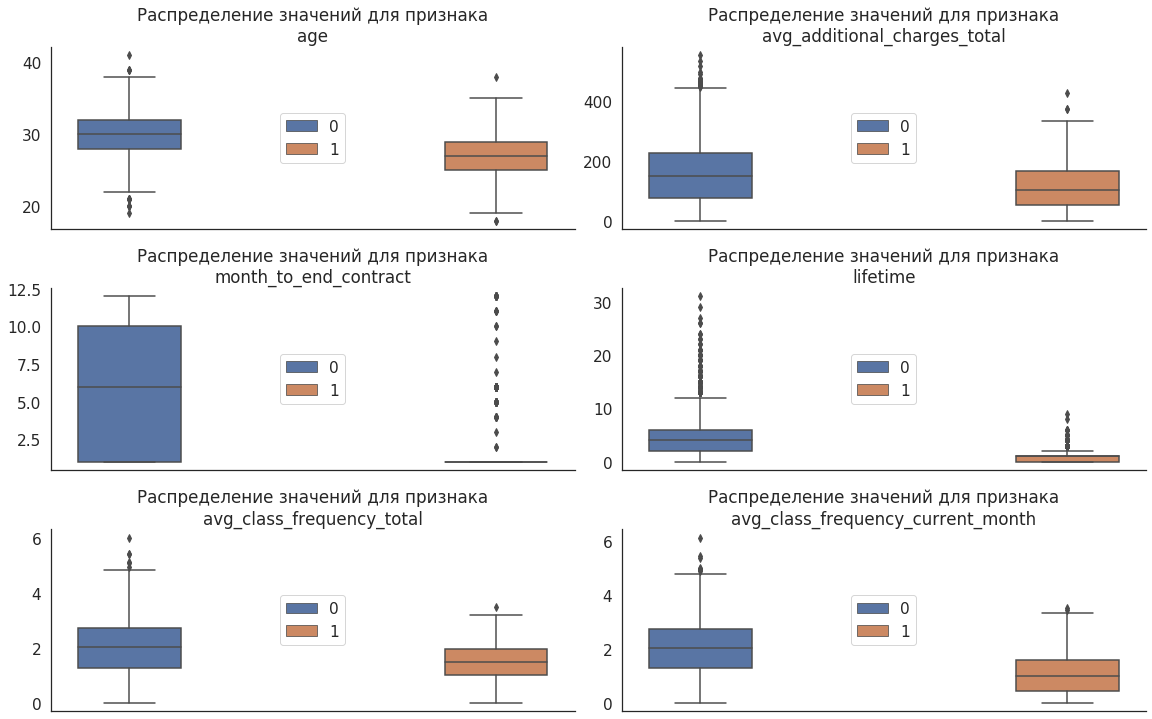

In [14]:
#Построим график распределения значений по признакам методом boxplot
box_plot(gym_df)

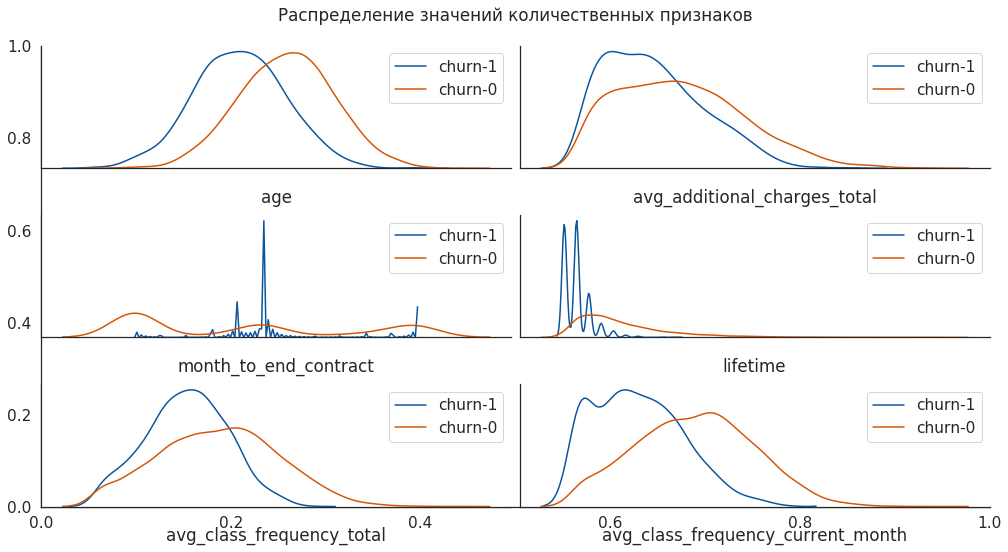

In [15]:
#Построим график распределения значений по признакам distplot    
n_rows = math.ceil(len(NUMERIC_COLUMNS)/2)
fg     = plt.figure(figsize=(14, 8))
gs     = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

plt.title('Распределение значений количественных признаков', pad=25)
for i in range(len(NUMERIC_COLUMNS)):
    
    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
    
    dist_plot(gym_df[gym_df['churn']==1][NUMERIC_COLUMNS[i]],
              'churn-1',
              sns.color_palette('Blues_r')[0],
              NUMERIC_COLUMNS[i])

    
    dist_plot(gym_df[gym_df['churn']==0][NUMERIC_COLUMNS[i]],
              'churn-0',
              sns.color_palette('YlOrBr_r')[1],
              NUMERIC_COLUMNS[i])
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(xlabel=NUMERIC_COLUMNS[i], labelpad=20)
sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)

Данные распределены в основном нормально. Мы видим смещение вправо на распределении признака `lifetime` и совсем не нормальное распределение для признака `month_to_end_contract`. Что с этим делать, мы решим после построения матрицы корреляций, возможно признак `month_to_end_contract` сильно коррелирует с какими-то другими признакими и мы его удалим. Действия с признаком `lifetime` будут зависить от выбранной модели обучения, в некоторых случаях предворительная нормализация не понадобится.

Для бинарных признаков гистограммы\распределения\боксплоты не очень показательны, так что для таких признаков построим столбчатые диаграммы, а для признака `month_to_end_contract` - тепловыю карту

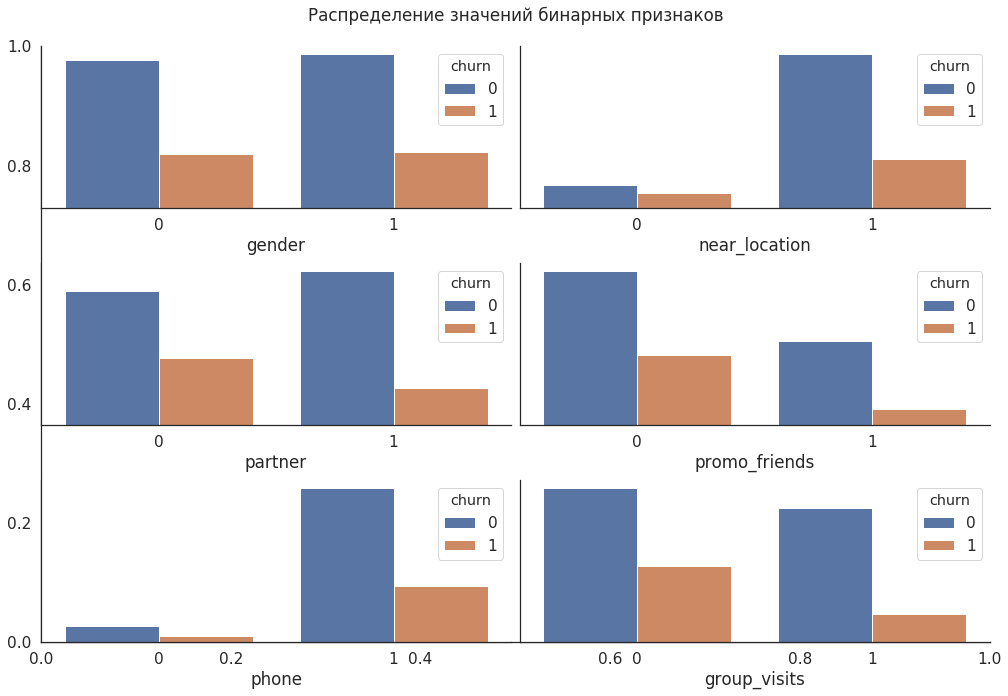

In [16]:
categorical_columns = CATEGORICAL_COLUMNS.copy()
categorical_columns.remove('contract_period')

#Построим график распределения значений ля бинарных признаков
n_rows = math.ceil(len(categorical_columns)/2)
fg     = plt.figure(figsize=(14, 10))
gs     = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

plt.title('Распределение значений бинарных признаков', pad=25)

for i in range(len(categorical_columns)):
    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
    df     = gym_df.groupby(['churn', categorical_columns[i]]).count().reset_index()
    df     = df[df.columns[:3]]
    sns.barplot(data=df,
                x=df.columns[1],
                y=df.columns[2],
                hue="churn")
    plt.ylabel('')
    plt.yticks([])
    
sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)

Признак ***пол***,  совсем не влияет на решение покинуть фитнес клуб. Партнерство и скидки ожидаемо положительно влияют на клиентов, они уходят реже. Так же заметно, что среди посещающих групповые занятия уровень оттока ниже.

In [17]:
#тепловая_карта
viz1 = gym_df.pivot_table(index='churn',
                 columns='contract_period',
                values='age',
                aggfunc='count')

fig = ff.create_annotated_heatmap(x=[0, 1, 2], z=viz1.values, showscale = True, colorscale='Oranges')
fig.update_layout(
    width=480,
    height=320,
    margin=dict(
            l=25,
            r=10,
            b=15,
            t=100,
            pad=5
        )
    
)
fig.update_yaxes(tickvals=[0, 1], ticktext=['Не ушел', 'Ушел'])
fig.update_xaxes(side="top", title='Contract period', tickvals=[0, 1, 2], ticktext=[1, 6, 12])
fig.show()

По признаку `contract_period` можно сказать, что среди ушедших в основном клиенты, посещающие клуб всего месяц.

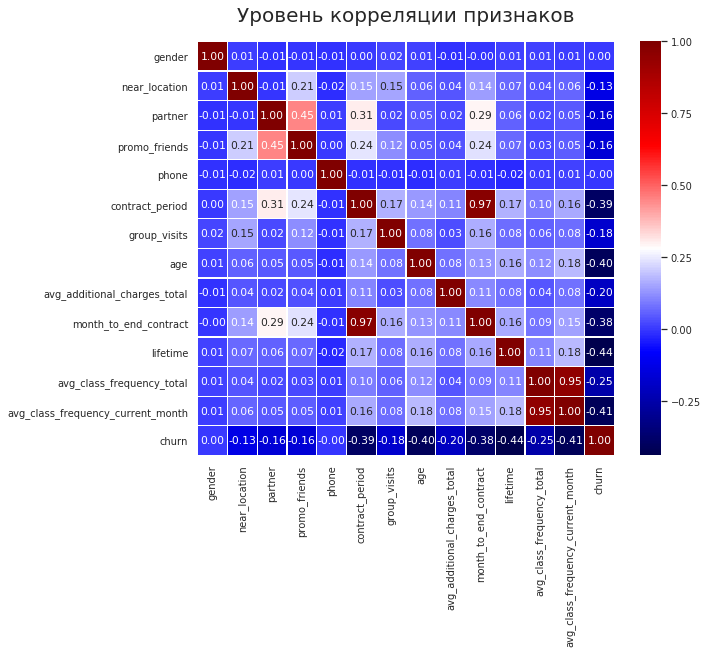

In [18]:
#Построим матрицу корреляций
heat_map(gym_df.corr(), fig_size=(10, 9), title='Уровень корреляции признаков')

In [19]:
#Удаление признаков с высоким уровнем корреляции
gym_df = gym_df.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)
gym_df.shape

(4000, 12)

In [20]:
#Теперь можно привести признаки к нужным типам
for col_name in CATEGORICAL_COLUMNS:
    gym_df[col_name] = gym_df[col_name].astype('object')

gym_df.dtypes

gender                           object
near_location                    object
partner                          object
promo_friends                    object
phone                            object
contract_period                  object
group_visits                     object
age                               int64
avg_additional_charges_total    float64
lifetime                          int64
avg_class_frequency_total       float64
churn                             int64
dtype: object

Теперь все значения-флаги имеют тип ***object***, что соответствует типу признака - категориальный.

В случае необходимости, для лучшей читаемости данных, категории переменных можно переименовать методами ***map()*** или ***rename()***

Например...

In [21]:
#Для столбца partner переименуем флаги 1 и 0 как 'партнер' и 'не партнер' соответственно
partner_categories = {1:'партнер',
                      0:'не партнер'}
gym_df['partner']  = gym_df['partner'].map(partner_categories)
gym_df.head(5)

gender near_location     partner promo_friends phone contract_period  \
0      1             1     партнер             1     0               6   
1      0             1  не партнер             0     1              12   
2      0             1     партнер             0     1               1   
3      0             1     партнер             1     1              12   
4      1             1     партнер             1     1               1   

  group_visits  age  avg_additional_charges_total  lifetime  \
0            1   29                     14.227470         3   
1            1   31                    113.202938         7   
2            0   28                    129.448479         2   
3            1   33                     62.669863         2   
4            0   26                    198.362265         3   

   avg_class_frequency_total  churn  
0                   0.020398      0  
1                   1.922936      0  
2                   1.859098      0  
3                   3.205633      0  
4                   1.113884      0

Но поскольку на выполнение нашей задачи эти изменения не влияют, оставим названия категорий без изменений

In [22]:
partner_categories_r = {'партнер':'1',
                        'не партнер':'0'}
gym_df               = gym_df.replace({'partner':partner_categories_r})
gym_df.head(5)

gender near_location partner promo_friends phone contract_period  \
0      1             1       1             1     0               6   
1      0             1       0             0     1              12   
2      0             1       1             0     1               1   
3      0             1       1             1     1              12   
4      1             1       1             1     1               1   

  group_visits  age  avg_additional_charges_total  lifetime  \
0            1   29                     14.227470         3   
1            1   31                    113.202938         7   
2            0   28                    129.448479         2   
3            1   33                     62.669863         2   
4            0   26                    198.362265         3   

   avg_class_frequency_total  churn  
0                   0.020398      0  
1                   1.922936      0  
2                   1.859098      0  
3                   3.205633      0  
4                   1.113884      0

**Шаг 2. Выводы**

Мы получили датафрейм состоящий из 4000 строк (наблюдений) и 13 столбцов (признаков) + 1 столбец (признак) - целевой показатель. Все 13 признаков - количественные. В ходе исследовательского анализа до разбиения данных на обучающую и контрольную выборки были выполнены следующие действия:

| | | |
|-|:-------|:--------|
|1|Проверка и преобразование в случае необходимости типов данных. |В исходном датасете все имеющиеся признаки имели тип ***int*** или ***float***, хотя исходя из описания данных, многие признаки содержали значения-флаги (выбор из двух категорий) и могли быть отнесены к категориальным данным. Типы приведены в соответствие.|
|2|Нормализация строковых значений. |Поскольку все наши признаки изначально количественные, то какого-либо расхождения в отображении значений после приведения к типу ***object*** не появилось. К единому виду методом ***lower()*** были приведены названия столбцов (признаков).|
|3|Поиск и обработка дублирующих наблюдений. |Датасет не содержит дублирующих наблюдений.|
|4|Поиск и обработка пропусков. |Датасет не содержит пропущенных наблюдений.|
|5|Проверка и удаление редких категорий. |Методом ***groupby()*** редких категорий не выявлено. Редкие категории являются источниками шума и негативно влияют на качество модели. При разбиении на обучающую и контрольную выборки такая категория может оказаться только в контрольной. В таком случае регрессионная модель не сможет вычислить прогноз.|
|6|Изучение средних значений и стандартного отклонения для количественных признаков. |Мы изучили средние значения и стандартное отклонение для количественных признаков отдельно для клиентов со значением признака ***churn*** равным 0 и 1. В целом можно сказать, что значения признаков для двух групп пользователей различаются, но не слишком сильно. Для признаков кроме ***month_to_end_contract*** и ***lifetime*** стандарное отклонение вполне допустимое, это все подтверждается графиками распределения, построенными методами ***distplot*** и ***boxplot***. Для признаков ***month_to_end_contract*** и ***lifetime*** различия в стандартном отклонении больше. Однако перед обучением модели мы стандартизируем данные и немного снизим эту разницу.|
|7|Изучение корреляции признаков. |Предсказуемо сильно коррелируют признаки ***avg_class_frequency_total*** с ***avg_class_frequency_current_month***, уровень - 0,95 и ***month_to_end_contract*** с **contract_period**, уровень - 0,97. Корреляция между остальными признаками не превышаетзначения 0,2|


Все готово для перехода ко третьему шагу в котором мы построим модель бинарной классификации клиентов, где целевым признаком будет факт оттока клиента в следующем месяце.

<a id='step_3'></a>
[*к шагу 2*](#step_2)

## Модель прогнозирования оттока клиентов.

[*к шагу 4*](#step_4)

**Поставленная задача относится к задаче бинарной классификации.**

Возможные алгоритмы обучения модели:
- логистическая регрессия;
- дерево принятия решений;
- случайный лес;
- градиентный бустинг.

Поскольку среди признаков нет признаков с высоким уровнем корреляции, то алгоритмы линейной регрессии, включающие в себя регуляризацию, такие как `Lasso regression` и `Ridge regression` нам не понядобятся.

Метрики оценки модели:
- доля правильных ответов (accuracy);
- точность (precision);
- полнота (recall).

**Разделение данных на обучающую и валидационную выборки.**

In [23]:
#Разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_df.drop('churn', axis=1)
y = gym_df['churn']

In [24]:
#Разделим модель на обучающую и валидационную выборки
#Параметр random_state=0 установлен только для получения одного и того же результата при решении и проверке
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Обучим алгоритмы, сделаем предсказания и сравним результаты.**

In [25]:
#Зададим алгоритмы для моделей
models = [LogisticRegression(solver='liblinear', random_state = 0),
          DecisionTreeClassifier(random_state = 0),
          RandomForestClassifier(n_estimators = 100, random_state = 0),
          GradientBoostingClassifier(n_estimators = 100, random_state = 0)]

**Посмотрим на матрицу ошибок для наших алгоритмов.**

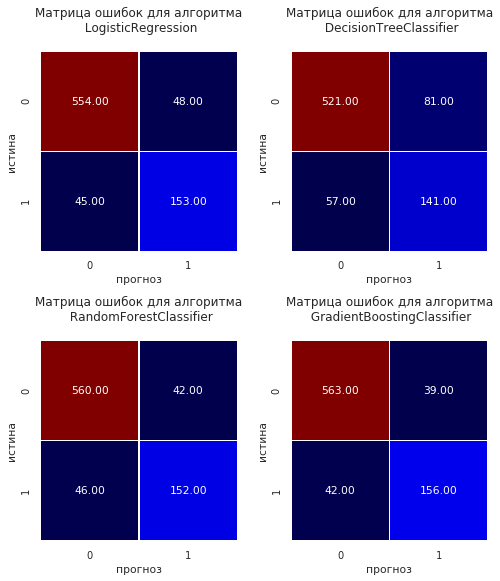

In [26]:
heat_map(models, fig_size=(7, 8), title=MODEL_NAMES, multi=True)

На вид очень не плохие результаты. 
Нарпимер для алгоритма ***LogisticRegression*** метрика ***Accuracy*** составит

(TP+TN) / (TP+TN+FP+FN) = (153+554) / (153+554+48+45) = 707 / 800 = ***88.38%***

In [27]:
models_tuned = [LogisticRegression(solver='liblinear', random_state = 0),
                DecisionTreeClassifier(random_state = 0),
                RandomForestClassifier(n_estimators = 100, random_state = 0),
                GradientBoostingClassifier(n_estimators = 100, random_state = 0)]

prediction_dict = {}

for i in range(len(models_tuned)):
    prediction_dict.setdefault(MODEL_NAMES[i], [])
    prediction_dict[MODEL_NAMES[i]] = make_prediction(models_tuned[i], MODEL_NAMES[i], X_train, y_train, X_test, y_test)
    
prediction_df = pd.DataFrame(data=np.array(list(prediction_dict.values())),
                             columns=['Accuracy', 'Precision', 'Recall', 'F1'])

prediction_df['Алгоритм'] = MODEL_NAMES

prediction_df.sort_values('F1', ascending=False).set_index('Алгоритм')

Accuracy  Precision  Recall     F1
Алгоритм                                                      
GradientBoostingClassifier     89.88      80.00   78.79  79.39
RandomForestClassifier         89.00      78.35   76.77  77.55
LogisticRegression             88.38      76.12   77.27  76.69
DecisionTreeClassifier         82.75      63.51   71.21  67.14

Так и есть, достаточно точные предсказания. При общей точности выше 80%, алгоритм ***DecisionTreeClassifier*** явно уступает остальным. Попробуем различные настройки.

In [28]:
models_tuned = [LogisticRegression(penalty='l1', solver='liblinear', random_state = 0),
                DecisionTreeClassifier(max_depth=5, random_state = 0),
                RandomForestClassifier(n_estimators = 100, min_samples_split=10, random_state = 0),
                GradientBoostingClassifier(loss='exponential', n_estimators = 100, random_state = 0)]

prediction_dict = {}

for i in range(len(models_tuned)):
    prediction_dict.setdefault(MODEL_NAMES[i], [])
    prediction_dict[MODEL_NAMES[i]] = make_prediction(models_tuned[i], MODEL_NAMES[i], X_train, y_train, X_test, y_test)
    
prediction_df_tuned = pd.DataFrame(data=np.array(list(prediction_dict.values())),
                             columns=['Accuracy', 'Precision', 'Recall', 'F1'])

prediction_df_tuned['Алгоритм'] = MODEL_NAMES

prediction_df_tuned.sort_values('F1', ascending=False).set_index('Алгоритм')

Accuracy  Precision  Recall     F1
Алгоритм                                                      
GradientBoostingClassifier     90.62      82.54   78.79  80.62
LogisticRegression             89.38      77.83   79.80  78.80
RandomForestClassifier         89.75      81.52   75.76  78.53
DecisionTreeClassifier         88.12      73.95   80.30  77.00

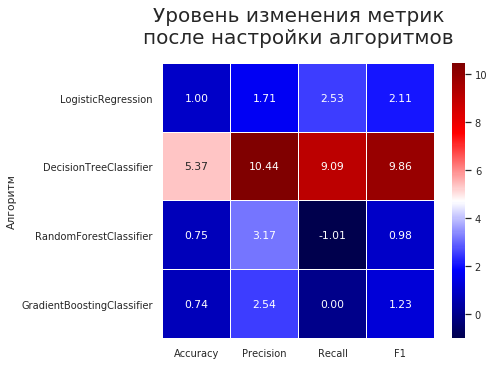

In [29]:
diff_df = prediction_df_tuned.set_index('Алгоритм') - prediction_df.set_index('Алгоритм')

heat_map(diff_df, fig_size=(7, 5), title='Уровень изменения метрик\nпосле настройки алгоритмов')

**Шаг 3. Выводы**

Немного настроив наши алгоритмы удалось улучшить точность всех четырех алгоритмов.
Алгоритм ***DecisionTreeClassifier*** без ограничения количества ветвей дает самый слабый результат 0.83, но если мы устанавливаем значение ***max_depth=5***, точность повышается до 0,88. Остальным алгоритмам точность удалось повысить не так заметно. Самым точным с результатом 0,91 оказался ***GradientBoostingClassifier***. Если же сравнивать предложенные в задании алгоритмы ***LogisticRegression*** и ***RandomForestClassifier***, то с минисальным преимуществом точнее ***RandomForestClassifier***, он же проигрывает по метрике ***Recall***, но на ту же разницу выигрывает по метрике ***Precision***.

Однако, непосредственно точность это доля угаданных ответов и тут важно соотношение классов. У нас оно примерно 1/3 - 602 клиента остались и 198 ушли. Если бы мы предположили, что все 602 клиента останутся на 100%, то ***Accuracy*** бы составил:

(TP+TN) / (TP+TN+FP+FN) = (153+602) / (153+602+0+45) = 755 / 800 = ***94.38%***

Поэтому,хотя ***Accuracy*** и имеет самый большой результат из метрик, ориентироваться мы будем не на него.

Следующие две наших метрики ***Precision*** и ***Recall*** - не зависаят от соотношения классов.

***Precision*** показывает процент, предсказанных алгоритмом положительных результатов, которые действительно оказались положительными. В нашем случае это процент клиентов, определенных алгоритмом, как оставшихся, и оставшихся на самом деле. Для алгоритма ***LogisticRegression*** эта метрика составила TP / (TP+FP) = 153 / (153+48) = ***76.12%*** (до перенастройки наших алгоритмов). 
 
Метрика ***Recall*** показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Для алгоритма ***LogisticRegression*** эта метрика составила TP / (TP+FN) = 153 / (153+45) = ***77.27%***

Надо сказать, что до перенастройки алгоритмов, разница между метриками ***Precision*** и ***Recall*** была более заметной. После настройки метрики ***Precision*** и ***Recall*** для алгоритма ***LogisticRegression*** составили ***77.83%*** и ***79.80%*** против бывших значений ***76.12%*** и ***77.27%*** соответственно.

Тут нам придется думать, насколько дорого нам обойдется обрабатывать каждого клиента, которого мы определили как потенциально уходящего. Если мы готовы потратить деньги на клиента, который и так не собирался уходить, то ориентируемся на  метрики ***RandomForestClassifier*** и ***GradientBoostingClassifier***, которые лучше прогназируют если оценивать метрикой ***Precision***. В случае если с ресурсом беда и готовы упустить несколько клиентов то используем ***LogisticRegression*** и ***DecisionTreeClassifier***.

Метрика ***F1*** - баланс между метриками. В наших прогнозах максимальное значение метрика ***F1*** принимает для алгоритма ***GradientBoostingClassifier***.

Из предложенных в задании алгоритмов ***RandomForestClassifier*** и ***LogisticRegression***, по метрике ***F1*** немного лучше второй.

<a id='step_4'></a>
[*к шагу 3*](#step_3)

**4. Кластеризация клиентов.**

[*к шагу 5*](#step_5)

- Стандартизация данных;
- Матрица расстояний;
- Обучение модели кластеризации на основании алгоритма K-Means;
- Средние значения признаков для кластеров;
- Распределения признаков для кластеров;
- Расчет доли оттока для каждого полученного кластера.

**Стандартизация данных**

В этом месте мы создадим копию датафрайма, в которой вернем всем столбцам числовой тип данных. Чтобы узнать, влияет ли тип данных на результат стандартизации. Хотя в мануале никаких ограничений на тип передаваемых данных, кроме того, что это должен быть ***array-like of shape***

In [30]:
X_num = X.copy()
for col_name in CATEGORICAL_COLUMNS:
    X_num[col_name] = X_num[col_name].astype('int')

In [31]:
sc       = StandardScaler()
X_sc     = sc.fit_transform(X)
X_num_sc = sc.fit_transform(X_num)
#Количество True значений в поэлементном сравнении стандартизированных признаков
np.count_nonzero(X_sc==X_num_sc, axis=None)

44000

In [32]:
#Количество ячеек в датафрейме
len(X)*len(X.columns)

44000

Тип данных признака не влияет на конечный результат, но мы все равно создадим срез датафрейма, содержащий только количественные признаки и сравним потом получившиеся кластеры. Как повлияет уменьшение количества признаков на модель? Потому что не очень понятно зачем стандартизировать признаки у которых только два значения.

In [33]:
NUMERIC_COLUMNS = X.columns[-4:]
X_num           = X[NUMERIC_COLUMNS].copy()
X_num_sc        = sc.fit_transform(X_num)

**Построение матрицы растояний**

Построим матрицу методом ***linkage()*** для двух наборов стандартизированных признаков: ***X_sc*** (все признаки) и ***X_num_sc*** (только количественные признаки)

Поскольку построение и визуализация матрицы по всем наблюдениям занимает не мало времени, полученный результат сохранен в виде файлов .png и доступен по ссылкам ниже.

[**Ссылка на дендограмму (полный набор признаков)**](https://yadi.sk/i/TEz9ZoiABNcuNA)

[**Ссылка на дендограмму (усеченный набор признаков)**](https://yadi.sk/i/ab0_C7utLkqAmw)

Быстрее можем произвести разбивку по тестовой выборке ***X_test***

In [34]:
#Создадим срез датафрейма
X_test_num    = X_test[NUMERIC_COLUMNS].copy()

#Стандартизтруем полный наброр признаков
X_test_sc     = sc.fit_transform(X_test)
#Стандартизтруем количественные признаки
X_test_num_sc = sc.fit_transform(X_test_num)

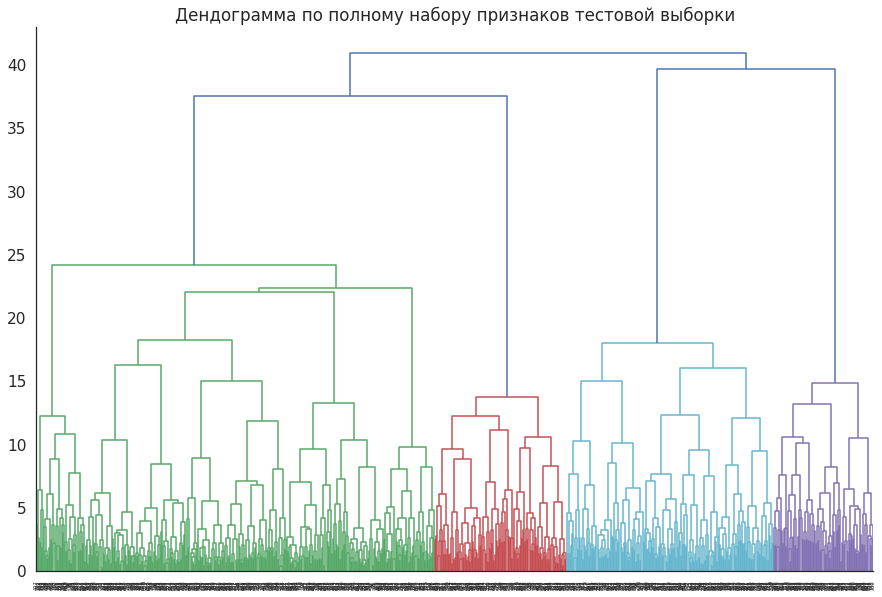

In [35]:
#Построение дендограммы по полному набору признаков тестовой выборки
sns.set(style='white',font_scale=1.4)
Z   = linkage(X_test_sc, 'ward', optimal_ordering=True)
fig = plt.figure(figsize=(15, 10))
dn  = dendrogram(Z, orientation='top')
plt.title('Дендограмма по полному набору признаков тестовой выборки')
sns.despine(bottom=False)
plt.show()

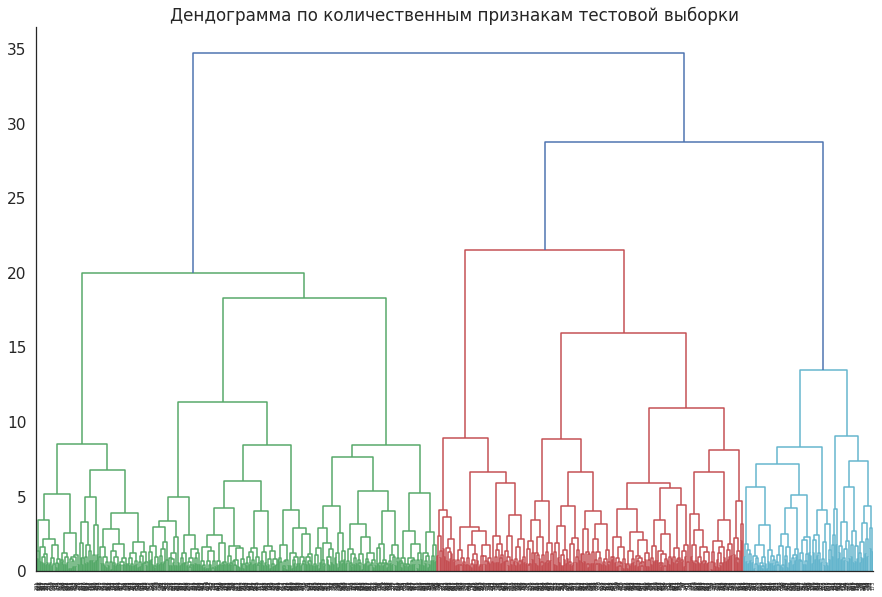

In [36]:
#Построение дендограммы по количественным признакам тестовой выборки
sns.set(style='white',font_scale=1.4)
Z_num = linkage(X_test_num_sc, 'ward', optimal_ordering=True)
fig   = plt.figure(figsize=(15, 10))
dn    = dendrogram(Z_num, orientation='top')
plt.title('Дендограмма по количественным признакам тестовой выборки')
sns.despine(bottom=False)
plt.show()

Интересно, что в случае обработки всех наблюдений, разделение на четыре кластера происходит как при обработки по всем признакам, так и только по категориальным. В случае с меньшим количеством признаков, разбивка получилась более равномерной. В случае с полным набором признаков одна из групп получилась практически равной трем остальным по размеру.

При работе только с тестовой группой, то есть только по части наблюдений, обработка всех признаков дала похожий результат, а вот при обработке только окличественных признаков алгоритм предложил три кластера, вместо четырех по всем наблюдениям.

**Обучение модели кластеризации на основании алгоритма K-Means. Прогноз кластеров клиентов.**

Поскольку алгоритм ***K-Means*** быстрее отрисовки дендограммы, мы можем использовать стандартизированные данные по полному набору наблюдений ***X_sc*** и ***X_num_sc*** и стандартизированные данные по тестовой выборке наблюдений ***X_test_sc*** и ***X_test_num_sc***.

In [37]:
km              = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5, несмотря ни на что))
labels          = km.fit_predict(X_sc) 
labels_num      = km.fit_predict(X_num_sc)
labels_test     = km.fit_predict(X_test_sc)
labels_test_num = km.fit_predict(X_test_num_sc)

**Средние значения признаков для кластеров. Первые выводы**

Для работы на этом этапе нам понадобится два набора наблюдений: ***X*** и ***X_test***

Добавим в каждый по два столбца с кластерами полученными от поного набора признаков и только от категориальных признаков. Назовем столбцы `cluster` и `cluster_num` и для начала оценим качество параматизации визуально, построив диаграммы рассеяния.

In [38]:
X_test                = X_test.copy()

X['cluster']          = labels
X['cluster_num']      = labels_num
X_test['cluster']     = labels_test
X_test['cluster_num'] = labels_test_num

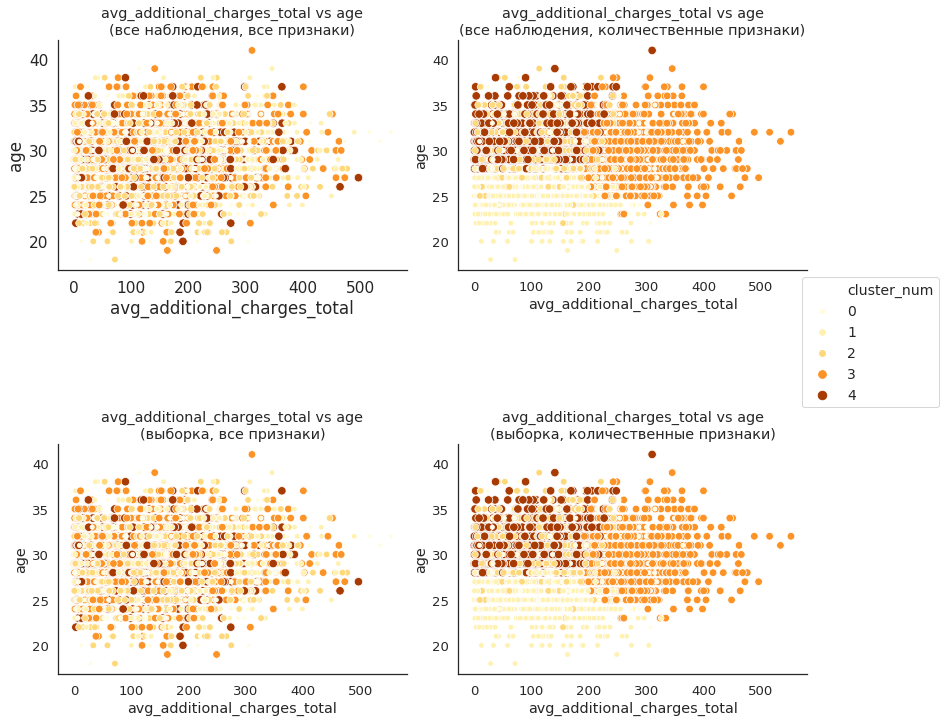

In [39]:
fg        = plt.figure(figsize=(13, 10))
gs        = gridspec.GridSpec(ncols=2, nrows=2, figure=fg)
legends   = [False, 'brief', False, False]
data      = [X, X, X_test, X_test]
hue_order = ['cluster','cluster_num','cluster','cluster_num']
text      = ['(все наблюдения, все признаки)', '(все наблюдения, количественные признаки)',
              '(выборка, все признаки)', '(выборка, количественные признаки)']

for i in range(len(NUMERIC_COLUMNS)):
    
    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
    scatter_plot(X,
                 'avg_additional_charges_total',
                 'age',
                 hue_order[i],
                 'YlOrBr',
                 legends[i],
                 text[i])

sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.2)

На мой взгляд количество кластеров, которые мы назначили не соответтсвует нашим потребностям. На дендограмме было видно, что оптимальным выбором было 4, а то и 3 кластера, а диаграмма рассеяния это доказывает. Лучше разделены кластеры на основе только количественных признаков (правый столбец). При кластеризации с учетом признаков, имеющих всего два параметра (левый столбец), качество разделения ниже.

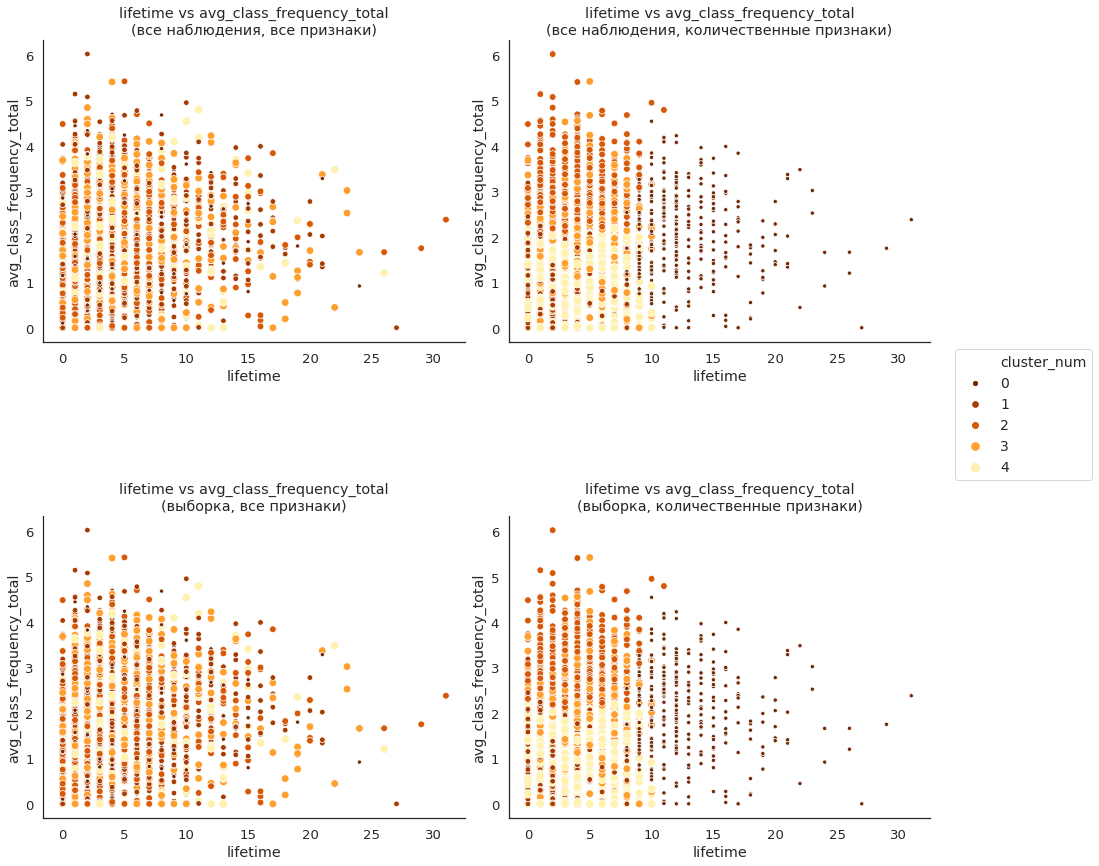

In [40]:
fg        = plt.figure(figsize=(15, 12))
gs        = gridspec.GridSpec(ncols=2, nrows=2, figure=fg)
legends   = [False, 'brief', False, False]
data      = [X, X, X_test, X_test]
hue_order = ['cluster','cluster_num','cluster','cluster_num']
text      = ['(все наблюдения, все признаки)', '(все наблюдения, количественные признаки)',
              '(выборка, все признаки)', '(выборка, количественные признаки)']

for i in range(len(NUMERIC_COLUMNS)):
    
    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
    scatter_plot(X,
                 'lifetime',
                 'avg_class_frequency_total',
                 hue_order[i],
                 'YlOrBr_r',
                 legends[i],
                 text[i])

sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.2)

Поменяв признаки, ситуация не изменилась. Качество разделения сложно оценить наглаз. Из пяти кластеров разделяются более-менее явно - три.

Кластаризация на основе всех наблюдений не сильно отличается от сделанной на основе выборки. Влияние количества и/или типа признаков гараздо сильнее.

- Оценим качество разделения по средним значениям признаков.

In [41]:
X.groupby('cluster').mean()[X.groupby('cluster').mean().columns[:-1]]

age  avg_additional_charges_total  lifetime  \
cluster                                                      
0        28.721925                    137.540009  3.060606   
1        29.543810                    155.861428  4.380952   
2        28.770318                    143.383993  3.343640   
3        29.536165                    148.088897  3.761194   
4        29.297927                    144.208179  3.940415   

         avg_class_frequency_total  
cluster                             
0                         1.770413  
1                         1.978963  
2                         1.800647  
3                         1.941342  
4                         1.854211

In [42]:
X.groupby('cluster_num').mean()[X.groupby('cluster_num').mean().columns[:-1]]

age  avg_additional_charges_total   lifetime  \
cluster_num                                                       
0            29.609572                    151.334968  12.284635   
1            25.540488                    111.825083   1.676098   
2            30.441074                    105.154225   3.394399   
3            29.853333                    279.158171   3.311515   
4            31.345982                    103.405754   2.972098   

             avg_class_frequency_total  
cluster_num                             
0                             2.060910  
1                             1.416782  
2                             2.975804  
3                             1.992148  
4                             1.174006

В целом цифры подтверждают, что разделение на основании только количественных данных качественнее. Что на мой взгляд логично. Сложно разделить два пола на пять категорий, как и любые признаки, имеющие пару параметров.

Теперь тоже самое, но по выборке...

In [43]:
X_test.groupby('cluster').mean()[X_test.groupby('cluster').mean().columns[:-1]]

age  avg_additional_charges_total  lifetime  \
cluster                                                      
0        29.868421                    143.709553  3.947368   
1        29.905263                    138.575896  3.715789   
2        29.096070                    158.950843  3.427948   
3        29.743719                    146.401466  4.381910   
4        28.600000                    129.276770  2.784000   

         avg_class_frequency_total  
cluster                             
0                         1.923985  
1                         1.709398  
2                         1.928563  
3                         1.993055  
4                         1.628092

In [44]:
X_test.groupby('cluster_num').mean()[X_test.groupby('cluster_num').mean().columns[:-1]]

age  avg_additional_charges_total   lifetime  \
cluster_num                                                       
0            30.981818                    267.754463   3.551515   
1            25.430769                    132.348655   1.846154   
2            30.544974                     77.624901   2.354497   
3            31.638710                    128.752214   3.277419   
4            29.062500                    125.902286  11.031250   

             avg_class_frequency_total  
cluster_num                             
0                             1.724727  
1                             1.671984  
2                             1.185807  
3                             3.085559  
4                             1.912632

Средние значения признаков доказывают, что разбивка на кластеры произошла качественнее в случаях обучения только на категориальных признаках. На примере признака ***age*** видно, что в случае с полным набором признаков каждому кластеру в среднем принадлежат люди одного возраста. Остальные признаки так же более разнообразно представлены при категоризации по количественным признакам.

**Рассмотрим распределения признаков для наших кластеров.**

- Сначала для сформированных по всем наблюдениям и признакам

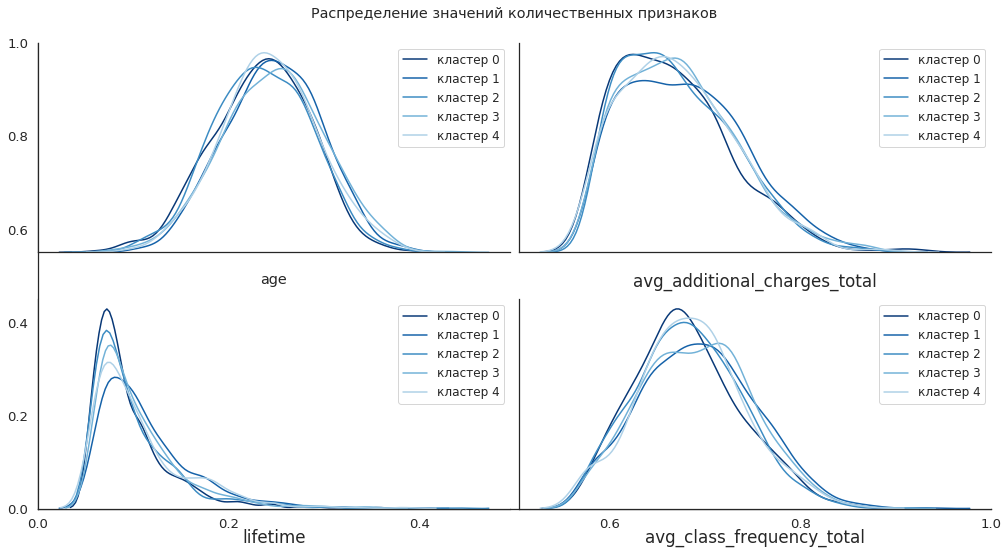

In [45]:
n_rows        = math.ceil(len(NUMERIC_COLUMNS)/2)
fg            = plt.figure(figsize=(14, 8))
gs            = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)
color_palette = sns.color_palette('Blues_r', n_colors=30)

plt.title('Распределение значений количественных признаков', pad=25)
for i in range(len(NUMERIC_COLUMNS)):
    
    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])
    
    for j in range(6):
        dist_plot(X[X['cluster']==j][NUMERIC_COLUMNS[i]],
                  'кластер '+str(j),
                  color_palette[j*5],
                  NUMERIC_COLUMNS[i])
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(xlabel=NUMERIC_COLUMNS[i], labelpad=20)
    plt.legend(fontsize=12)

sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)

Очень хорошо видно, что группы получились практически одинаковые. Определить по таким, кто из клиентов возможно покинет наш фитнес клуб мы врядли сможем.

- Теперь посмотрим распределение для кластеров, полученных на основании только количнественных данных.

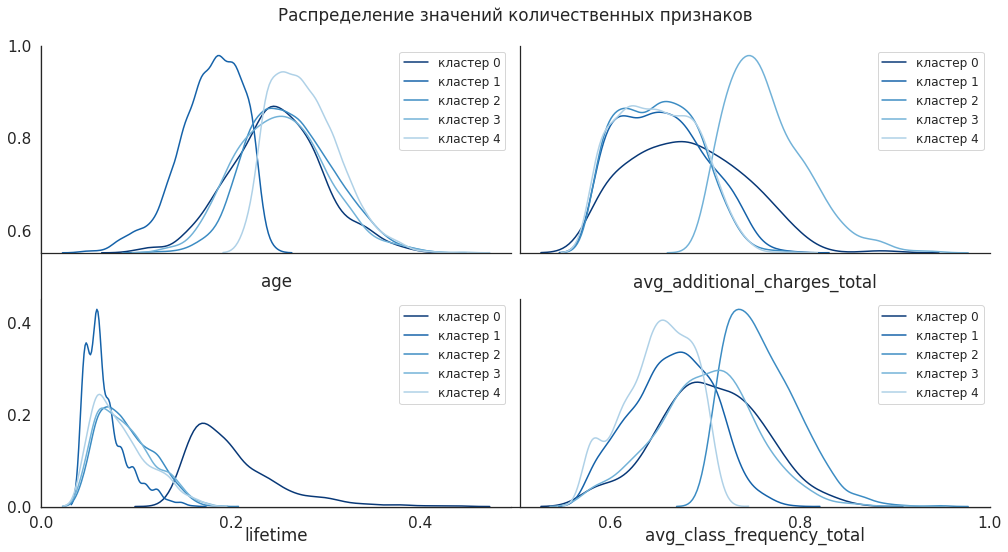

In [46]:
n_rows        = math.ceil(len(NUMERIC_COLUMNS)/2)
fg            = plt.figure(figsize=(14, 8))
gs            = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)
color_palette = sns.color_palette('Blues_r', n_colors=30)

plt.title('Распределение значений количественных признаков', pad=25)
for i in range(len(NUMERIC_COLUMNS)):

    fig_ax = fg.add_subplot(gs[Y_COORDINATES[i], X_COORDINATES[i]])

    for j in range(6):
        dist_plot(X[X['cluster_num']==j][NUMERIC_COLUMNS[i]],
                  'кластер '+str(j),
                  color_palette[j*5],
                  NUMERIC_COLUMNS[i])
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(xlabel=NUMERIC_COLUMNS[i], labelpad=20)
    plt.legend(fontsize=12)

sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)

Тоже не идеально, но все же кластеры получились более разнообразными. Пока все методы оценки качества разделения на кластеры показывают, что лучший результат достигнут разделением по количественным признакам, а выборка или все наблюдения, не столь важно.

Осталось оценить разделение метрикой силуета, методом ***silhouette_score***.

In [47]:
sc_df = pd.DataFrame({'выборка'         :['Все наблюдения, все признаки','Все наблюдения, количественные признаки',
                                          'Тестовая выборка, все признаки','Тестовая выборка, количественные признаки'],
                      'silhouette_score':[round(silhouette_score(X_sc, labels),4),
                                          round(silhouette_score(X_num_sc, labels_num),4),
                                          round(silhouette_score(X_test_sc, labels_test),4),
                                          round(silhouette_score(X_test_num_sc, labels_test_num),4)]})

sc_df.sort_values('silhouette_score', ascending=False).set_index('выборка')

silhouette_score
выборка                                                    
Тестовая выборка, количественные признаки            0.2100
Все наблюдения, количественные признаки              0.2094
Все наблюдения, все признаки                         0.1408
Тестовая выборка, все признаки                       0.1341

Ну что же, все вышесказанное о разнице в качестве кластаризации подтвердилось и визуально, и с помощью мерик. Разделение на кластеры на основании только количественных признаков дает более качественный результат.

**Расчет доли оттока для каждого полученного кластера.**

In [48]:
X['churn']        = y
X_test['churn']   = y_test
churn_percent     = []
churn_num_percent = []

for i in range(5):
    churn_percent.append(round(X.groupby('cluster').agg({'churn':'mean'}).at[i,'churn']*100,2))
    churn_num_percent.append(round(X.groupby('cluster_num').agg({'churn':'mean'}).at[i,'churn']*100,2))

churn_df = pd.DataFrame({'cluster'          :np.arange(0,5),
                         'churn_percent'    :churn_percent,
                         'churn_num_percent':churn_num_percent})

#Процент оттока по кластерам на основе всех признаков
churn_df.sort_values('churn_percent',
                     ascending=False
                    ).set_index('cluster')[['churn_percent']
                                          ].join(X.groupby('cluster').mean()[X.groupby('cluster').mean().columns[:-1]]
                                                ).drop('cluster_num', axis=1)

churn_percent        age  avg_additional_charges_total  lifetime  \
cluster                                                                     
0                39.93  28.721925                    137.540009  3.060606   
2                38.16  28.770318                    143.383993  3.343640   
4                26.68  29.297927                    144.208179  3.940415   
3                20.09  29.536165                    148.088897  3.761194   
1                12.10  29.543810                    155.861428  4.380952   

         avg_class_frequency_total  
cluster                             
0                         1.770413  
2                         1.800647  
4                         1.854211  
3                         1.941342  
1                         1.978963

In [49]:
#Процент оттока по кластерам на основе количественных признаков
churn_df.sort_values('churn_num_percent',
                     ascending=False
                    ).set_index('cluster')[['churn_num_percent']
                                          ].join(X.groupby('cluster_num').mean()[X.groupby('cluster_num').mean().columns[:-1]]
                                                ).drop('cluster', axis=1)

churn_num_percent        age  avg_additional_charges_total  \
cluster                                                               
1                    65.85  25.540488                    111.825083   
4                    23.21  31.345982                    103.405754   
3                    12.73  29.853333                    279.158171   
2                     8.40  30.441074                    105.154225   
0                     0.25  29.609572                    151.334968   

          lifetime  avg_class_frequency_total  
cluster                                        
1         1.676098                   1.416782  
4         2.972098                   1.174006  
3         3.311515                   1.992148  
2         3.394399                   2.975804  
0        12.284635                   2.060910

На последнем этапе мы проделали следующие действия:

- Стандартизация данных:

В качестве эксперимента мы создали две матрицы стандартизированных данных, чтобы проверить как повлияет на качество кластеризации количество признаков. Первая матрица включает все 12 признаков (мы удалили два сильно коррелирующих признака), вторая состоит токо из 4, поскольку включает в себя только количественные признаки. Для проверки влияния количества наблюдений на качество кластаризации мы создали такие стандартизированные матрицы из полного набора наблюдений (4000) и из тестовой выборки(800).

- Матрица расстояний:

Алгоритм агломеративной иерархической кластеризации по 3 из 4 стандартизированных массивов данных рекомендовал создание 4 кластеров а по данным тестовой выбоки по 4 признакам - 3 кластера.

- Обучение модели кластеризации на основании алгоритма K-Means:

Мы обучили 4 модели. Дальнейшее сравнение показало, что более успешно кластеризация прошла по данным, основанным только на количественных признаках. Что в целом логично. Большая часть данных - категориальные, и то что значения представлены в числовом виде не делают их количественными.

- Средние значения признаков для кластеров;

Средние значения признаков доказали, что разбивка на кластеры произошла качественнее в случаях обучения только на категориальных признаках. На примере признака ***age*** видно, что в случае с полным набором признаков каждому кластеру в среднем принадлежат люди одного возраста. Остальные признаки так же более разнообразно представлены при категоризации по количественным признакам.

- Распределения признаков для кластеров;

Для кластеров, разделенных по 12 признакам, распределения оказались слишком похожи, кластеры не сильно отличаются друг от друга.

- Расчет доли оттока для каждого полученного кластера.

Не смотря на довольно не высокую оценку кластеризации полученную методом ***silhouette_score***, некоторые выводы и прогнозы все-таки сделать можно. В группе риска клиенты, которые приобрели карту менее 2 месяцев назад, и посещают зал два и меньше раз в неделю.

<a id='step_5'></a>
**5. Выводы и базовые рекомендации по работе с клиентами.**

Для прогносирования оттока клиентов нашего фитнес клуба мы получили датафрейм состоящий из 4000 строк (наблюдений) и 13 столбцов (признаков) + 1 столбец (признак) - целевой показатель. Все 13 признаков - количественные, хотя исходя из описания данных, многие признаки содержали значения-флаги (выбор из двух категорий) и могли быть отнесены к категориальным данным. Типы приведены в соответствие. Поскольку все наши признаки изначально количественные, то какого-либо расхождения в отображении значений после приведения к типу ***object*** не появилось. Датасет не содержит дублирующих наблюдений и пропущенных наблюдений. Редких категорий, являющихся источниками шума и негативно влияющими на качество модели не обнаружено.

Мы изучили средние значения и стандартное отклонение для количественных признаков отдельно для клиентов со значением признака ***churn*** равным 0 и 1. В целом можно сказать, что значения признаков для двух групп пользователей различаются, но не слишком сильно. По первым оценкам определить портрет потенциально уходящего клиентане получилось.

Предсказуемо сильно коррелируют признаки ***avg_class_frequency_total*** с ***avg_class_frequency_current_month***, уровень - 0,95 и ***month_to_end_contract*** с **contract_period**, уровень - 0,97. Корреляция между остальными признаками не превышает значения 0,2. Признаки с высоким уровнем корреляции были удплены.

Третий этап нашего исследования был посвящен созданию моделей прогнозирования оттока клиентов. Поставленная задача относится к задаче бинарной классификации со следующими возможными алгоритмами обучения модели:

- логистическая регрессия;
- дерево принятия решений;
- случайный лес;
- градиентный бустинг.

Поскольку среди признаков нет признаков с высоким уровнем корреляции, то алгоритмы линейной регрессии, включающие в себя регуляризацию, такие как `Lasso regression` и `Ridge regression` мы не использовали. 

Для оценки моделей были использованы следующие модели:

- доля правильных ответов (accuracy);
- точность (precision);
- полнота (recall).

В результате тестирования и настройки моделей точность всех четырех алгоритмов привысила 82%. Однако, непосредственно точность это доля угаданных ответов и тут важно соотношение классов. У нас оно примерно 1/3 - 602 клиента остались и 198 ушли. Если бы мы предположили, что все 602 клиента останутся на 100%, то ***Accuracy*** бы составил:

(TP+TN) / (TP+TN+FP+FN) = (153+602) / (153+602+0+45) = 755 / 800 = ***94.38%***

В виду ненадежности метрики ***Accuracy*** мы изучили еще две метрики ***Precision*** и ***Recall***, которые не зависаят от соотношения классов. Надо сказать, что до перенастройки алгоритмов, разница между метриками ***Precision*** и ***Recall*** была более заметной. После настройки метрики ***Precision*** и ***Recall*** для алгоритма ***LogisticRegression*** составили ***77.83%*** и ***79.80%*** против бывших значений ***76.12%*** и ***77.27%*** соответственно. То есть алгороитм стал более сбалансированный.

Выбирая модель нам придется думать, насколько дорого нам обойдется обрабатывать каждого клиента, которого мы определили как потенциально уходящего. Если мы готовы потратить деньги на клиента, который и так не собирался уходить, то ориентируемся на  метрики ***RandomForestClassifier*** и ***GradientBoostingClassifier***, которые лучше прогназируют если оценивать метрикой ***Precision***. В случае если с ресурсом беда и готовы упустить несколько клиентов то используем ***LogisticRegression*** и ***DecisionTreeClassifier***.

Метрика ***F1*** - баланс между метриками. В наших прогнозах максимальное значение метрика ***F1*** принимает для алгоритма ***GradientBoostingClassifier*** .

Из предложенных в задании алгоритмов ***RandomForestClassifier*** и ***LogisticRegression***, по метрике ***F1*** немного лучше второй.

На последнем этапе мы разделили клиентов на пять кластеров и в результате исследования средних значений и распределений  признаков, спрогнозировали средний процент оттока для полученных кластеров.

Не смотря на довольно не высокую оценку кластеризации полученную методом ***silhouette_score***, некоторые выводы и прогнозы все-таки сделать можно.

Средний возраст склонного к оттоку клиента - 25 лет. Хотя ориентироваться на возраст я бы не рекомендовал. Cлишком маленькая разница среднего возраста по кластерам. А вот два критерия, котрые сильно выделяются это:

- время с момента первого обращения в фитнес-центр (lifetime);

- средняя частота посещений в неделю за все время с начала действия абонемента (avg_class_frequency_total)

В группе риска клиенты, которые приобрели карту менее 2 месяцев назад, и посещают зал два и меньше раз в неделю. Именно для таких клиентов уровень оттока составляет ***65.85%***. Ближе к трем месяцам посещения клуба риск, что клиент уйдет падает до ***23.21%***. А после трех месяцев составляет около ***10%*** и падает.

Так же при рассмотрении категориальных признаков в третьем шаге, мы увидили среди оставшихся клиентов большое количество посещающих групповые занятия.

Следует стимулировать регулярное посещение зала, воробатывать привычку. 
Возможная мотивация:

- скидка на услуги фитнес клуба, которая растет именно от количества и регулярности посещений и снижается за пропуски;
- соревнования между новичками, с целью добиться определенного результата за ограниченное время;
- бонусы, связанные с групповыми тренировками, например посети три типа групповых тренировок за неделю и массаж в подарок.